In [1]:
# Basic Imports
import matplotlib.pyplot as plt
import pandas as pd

# Sci-kit learn imports
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
# 1 - Load CSV file
penguins = pd.read_csv("penguins.csv")

In [3]:
# 1 a) i) Convert categorical features to dummy code (1-hot encoding)
data = pd.get_dummies(penguins, columns=['island', 'sex'], dtype=int)
X = data.to_numpy()[:, 1:10]
y = data.to_numpy()[:, 0]

In [4]:
# 1 a) ii) Convert features into categories
peng_array = penguins.to_numpy()
'''
for feature in peng_array:
    if feature[1] == "Torgersen":
        feature[1] = 0
    if feature[1] == "Dream":
        feature[1] = 1
    if feature[1] == "Biscoe":
        feature[1] = 2
    if feature[6] == "MALE":
        feature[6] = 0
    if feature[6] == "FEMALE":
        feature[6] = 1

X = peng_array[:, 1:7]
y = peng_array[:, 0]
'''

'\nfor feature in peng_array:\n    if feature[1] == "Torgersen":\n        feature[1] = 0\n    if feature[1] == "Dream":\n        feature[1] = 1\n    if feature[1] == "Biscoe":\n        feature[1] = 2\n    if feature[6] == "MALE":\n        feature[6] = 0\n    if feature[6] == "FEMALE":\n        feature[6] = 1\n\nX = peng_array[:, 1:7]\ny = peng_array[:, 0]\n'

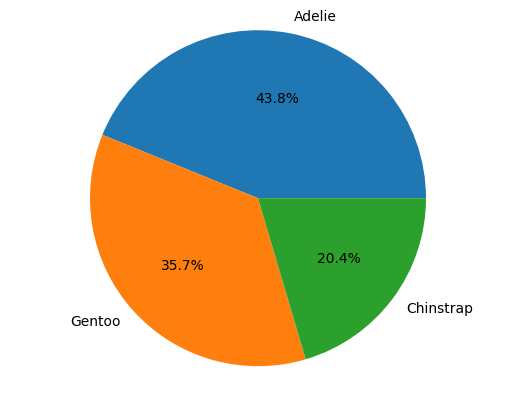

In [5]:
# 2 - Percentages of each output class
labels = 'Adelie', 'Gentoo', 'Chinstrap'
sizes = penguins['species'].value_counts(normalize=True) * 100

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig1.savefig("penguin-classes")

In [6]:
# 3 - Split the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y)

dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

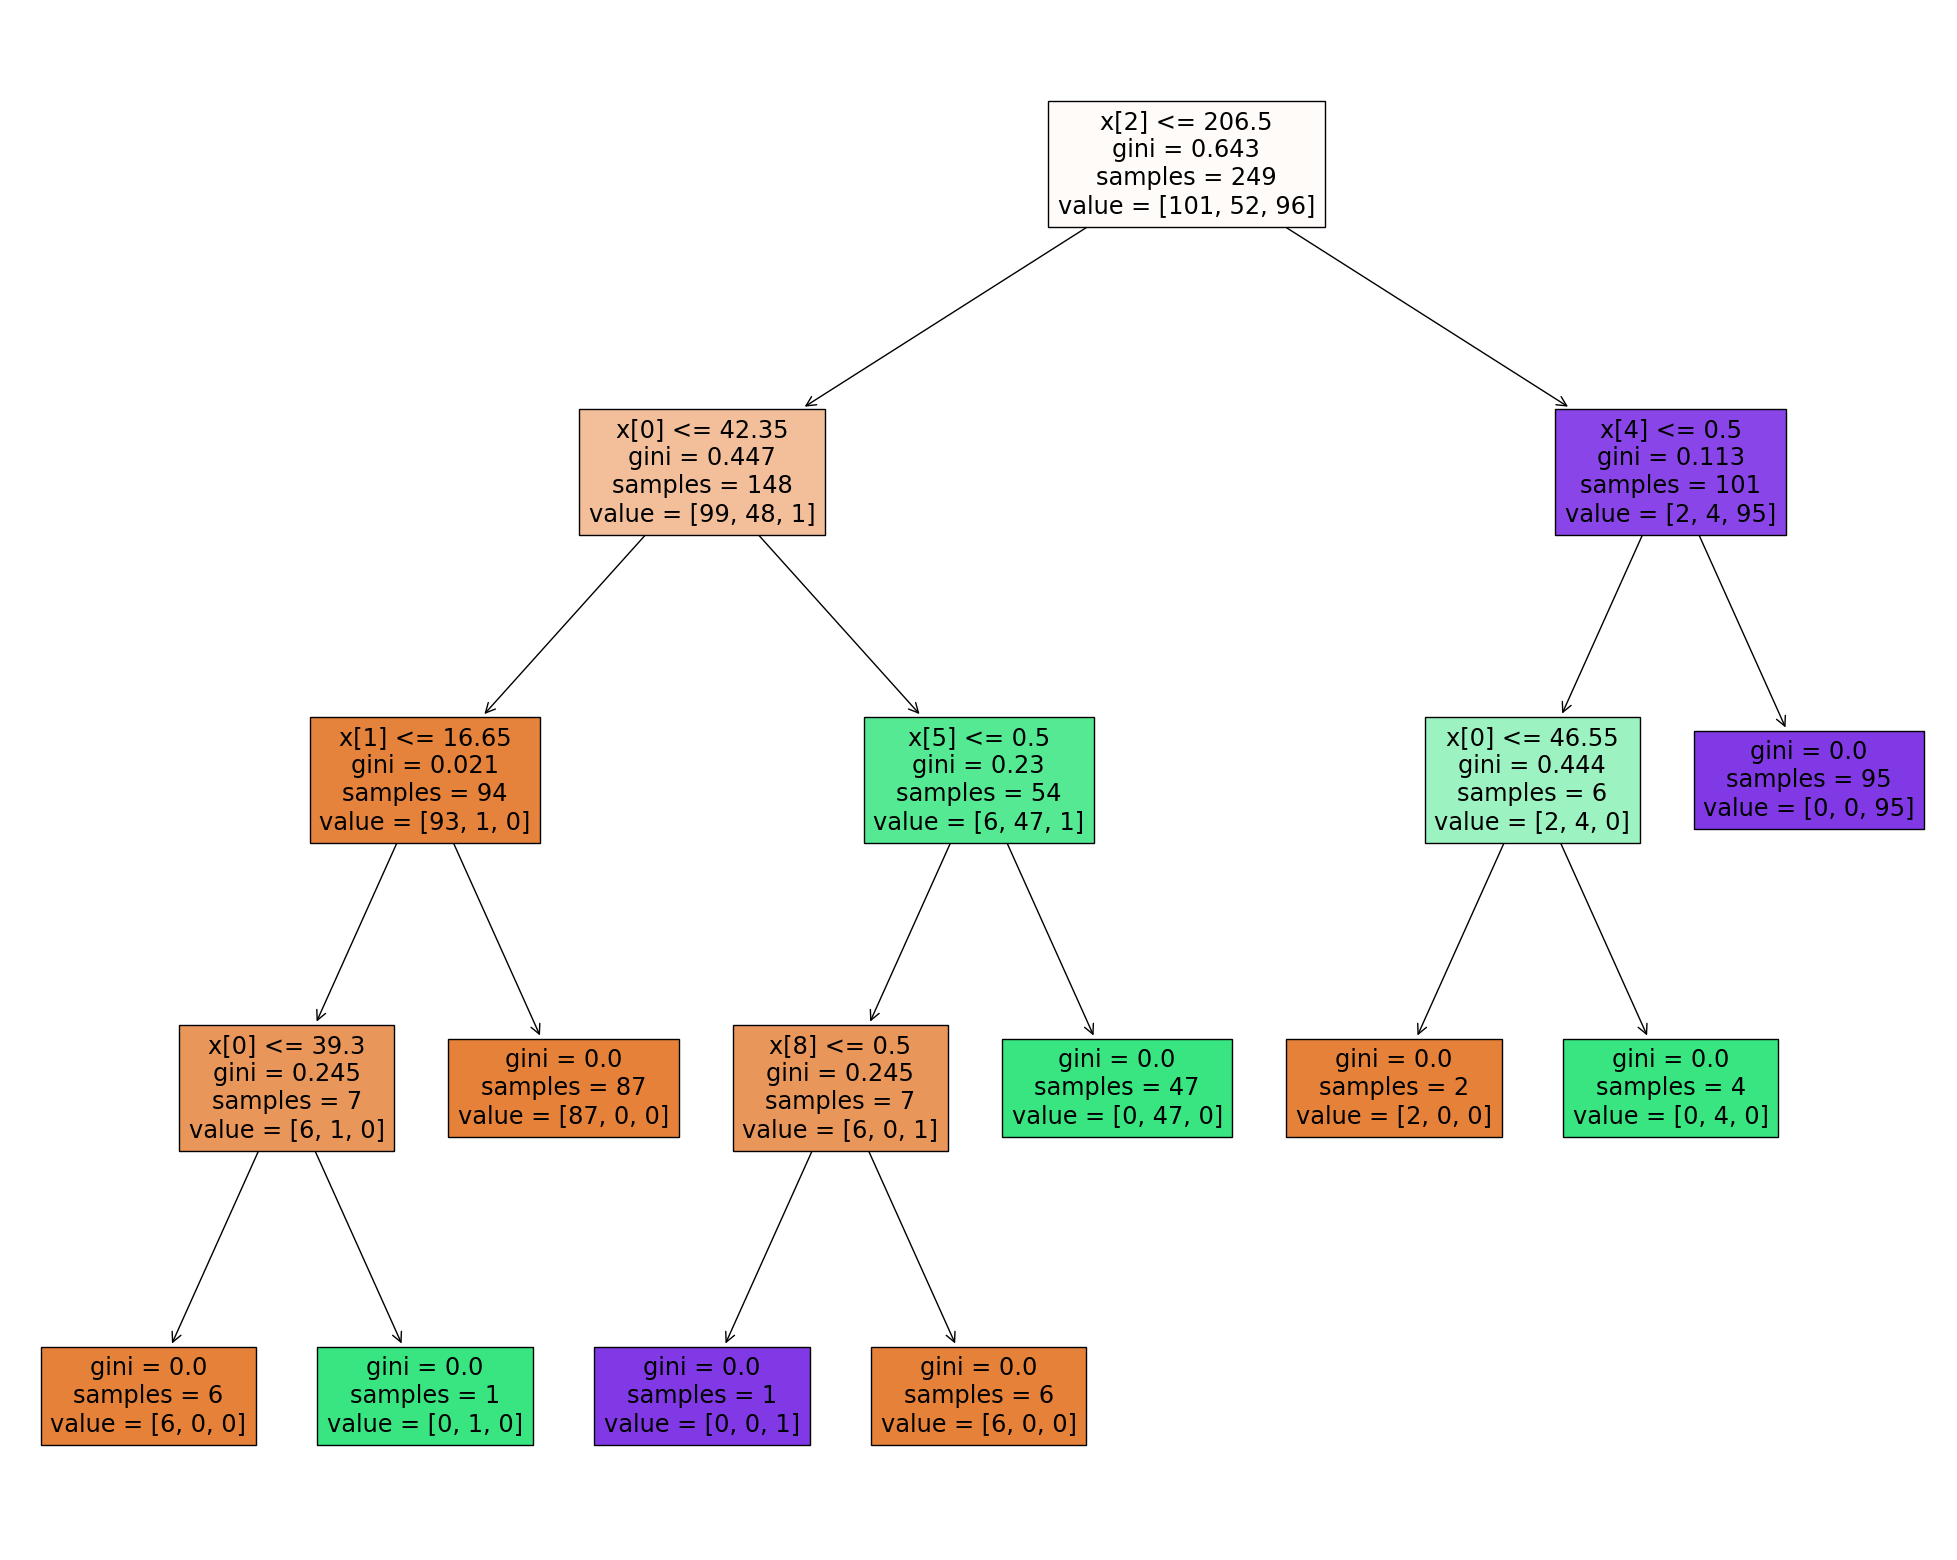

In [7]:
# 4 a) Base DT
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtc, filled=True)

In [8]:
# 4 b) Top DT
tree_para = {'criterion':['gini','entropy'],'max_depth':[3,7,None], 'min_samples_split':[2,3,5]}
dtc2 = tree.DecisionTreeClassifier()
grid = GridSearchCV(dtc2, tree_para)
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
0.9839183673469387


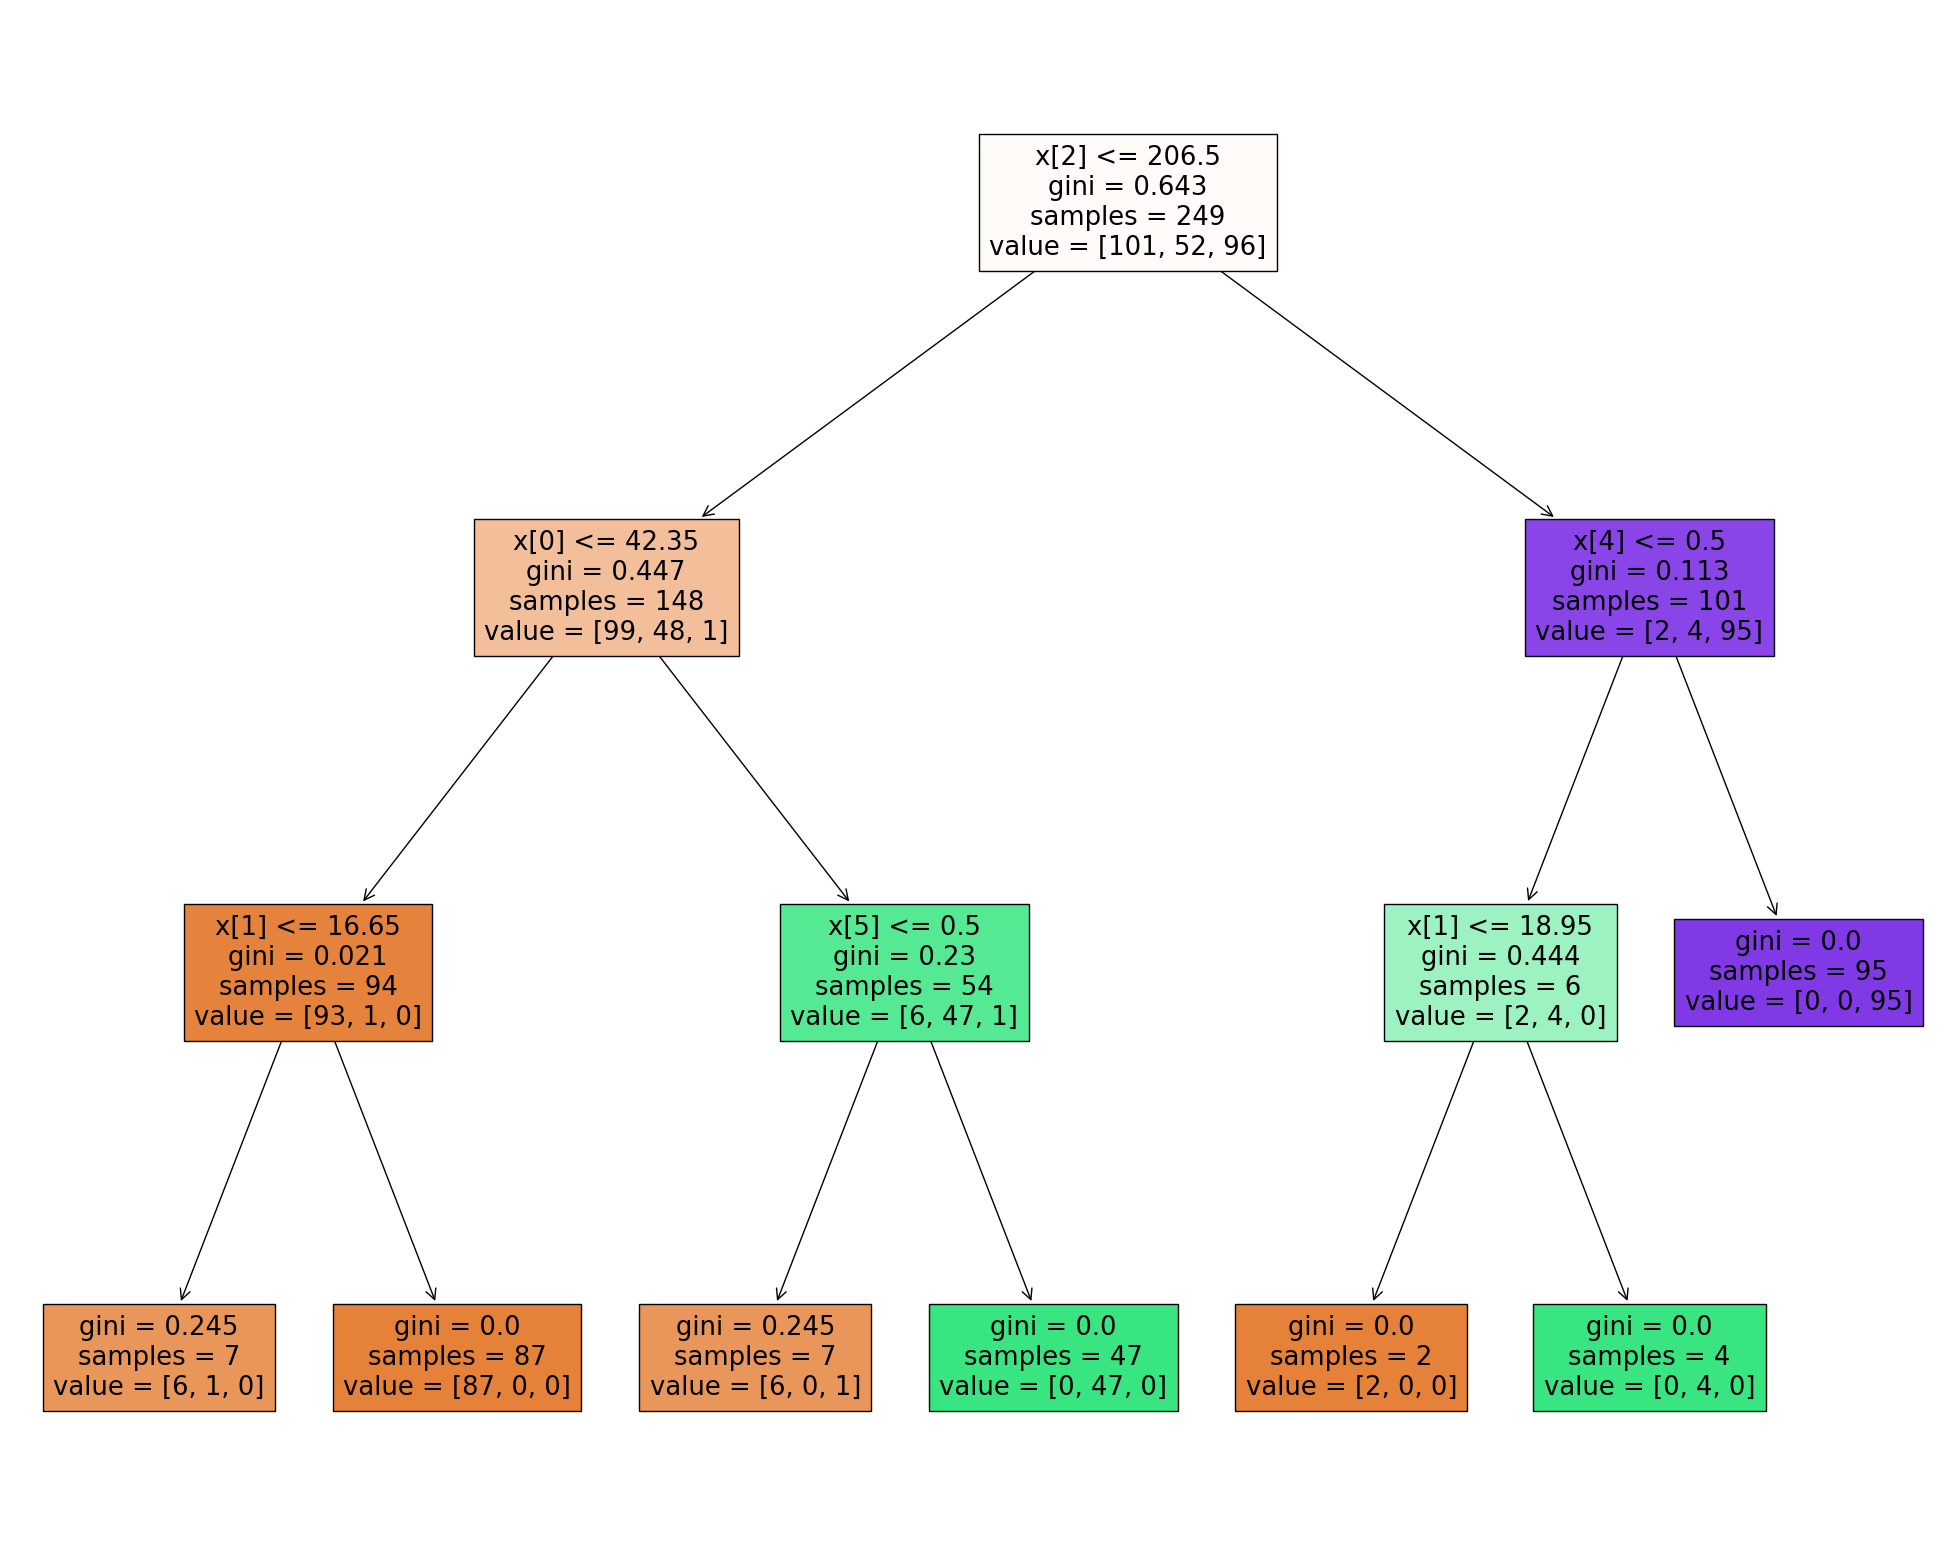

In [10]:
# Plot Top DT
top_dtc = tree.DecisionTreeClassifier()
top_dtc.set_params(**grid.best_params_)
top_dtc.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(top_dtc, filled=True)